# 기상 데이터 예측

# 기본 모듈

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston, load_iris, load_wine

from sklearn.linear_model import Ridge,Lasso,ElasticNet, LinearRegression, SGDRegressor, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import math

import mglearn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.simplefilter('ignore')

import requests
import time
from xml.etree import ElementTree
from datetime import date
from dateutil.relativedelta import relativedelta
from lxml import html
from bs4 import BeautifulSoup


In [2]:
import requests
from xml.etree import ElementTree 

url = 'https://www.weather.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'
response = requests.get(url)
tree = ElementTree.fromstring(response.content)
elements = tree.iter("location")

df = []
test = 0
for el in elements:
    city = el.find("city").text
    for data in el.iter('data'):
        tmEf = data.find('tmEf').text
        wf = data.find('wf').text
        tmn = data.find('tmn').text
        tmx = data.find('tmx').text
        
        df.append([city,tmEf,wf,tmn,tmx])
        

df = pd.DataFrame(df, columns =['city','tmEf','wf','tmn','tmx'])
df

,city,tmEf,wf,tmn,tmx
0,서울,2021-07-26 00:00,맑음,26,35
1,서울,2021-07-26 12:00,맑음,26,35
2,서울,2021-07-27 00:00,맑음,25,35
3,서울,2021-07-27 12:00,맑음,25,35
4,서울,2021-07-28 00:00,맑음,25,34
...,...,...,...,...,...
450,여주,2021-07-30 00:00,구름많음,22,32
451,여주,2021-07-30 12:00,구름많음,22,32
452,여주,2021-07-31 00:00,구름많음,23,33
453,여주,2021-08-01 00:00,구름많음,24,31


In [3]:
df['ntmn'] = df['tmn']
df['ntmx'] = df['tmx']
for i in range(len(df)) :
    if i < 454 :
        df['ntmn'][i] = df['tmn'][i+1]
        df['ntmx'][i] = df['tmx'][i+1]
    else :
        pass

df

lst = list(range(0, 455))
lst = [lst[i] % 13 != 12 for i in range(len(lst))]
df_remove = df[lst]
df_remove.head(40)

,city,tmEf,wf,tmn,tmx,ntmn,ntmx
0,서울,2021-07-26 00:00,맑음,26,35,26,35
1,서울,2021-07-26 12:00,맑음,26,35,25,35
2,서울,2021-07-27 00:00,맑음,25,35,25,35
3,서울,2021-07-27 12:00,맑음,25,35,25,34
4,서울,2021-07-28 00:00,맑음,25,34,25,34
...,...,...,...,...,...,...,...
450,여주,2021-07-30 00:00,구름많음,22,32,22,32
451,여주,2021-07-30 12:00,구름많음,22,32,23,33
452,여주,2021-07-31 00:00,구름많음,23,33,24,31
453,여주,2021-08-01 00:00,구름많음,24,31,24,31


In [20]:
lst = list(range(0, 455))
lst = [lst[i] % 13 != 12 for i in range(len(lst))]
df_remove = df[lst]

,city,tmEf,wf,tmn,tmx,ntmn,ntmx
0,서울,2021-07-26 00:00,맑음,26,35,26,35
1,서울,2021-07-26 12:00,맑음,26,35,25,35
2,서울,2021-07-27 00:00,맑음,25,35,25,35
3,서울,2021-07-27 12:00,맑음,25,35,25,34
4,서울,2021-07-28 00:00,맑음,25,34,25,34
5,서울,2021-07-28 12:00,맑음,25,34,25,34
6,서울,2021-07-29 00:00,맑음,25,34,25,34
7,서울,2021-07-29 12:00,맑음,25,34,25,34
8,서울,2021-07-30 00:00,구름많음,25,34,25,34
9,서울,2021-07-30 12:00,구름많음,25,34,26,35


In [19]:
df_remove = df[lst]
df_remove

,city,tmEf,wf,tmn,tmx,ntmn,ntmx
0,서울,2021-07-26 00:00,맑음,26,35,26,35
1,서울,2021-07-26 12:00,맑음,26,35,25,35
2,서울,2021-07-27 00:00,맑음,25,35,25,35
3,서울,2021-07-27 12:00,맑음,25,35,25,34
4,서울,2021-07-28 00:00,맑음,25,34,25,34
...,...,...,...,...,...,...,...
449,여주,2021-07-29 12:00,맑음,22,32,22,32
450,여주,2021-07-30 00:00,구름많음,22,32,22,32
451,여주,2021-07-30 12:00,구름많음,22,32,23,33
452,여주,2021-07-31 00:00,구름많음,23,33,24,31


In [21]:
# 1. 일교차 구하기 
df['tmn'] = pd.to_numeric(df['tmn'])
df['tmx'] = pd.to_numeric(df['tmx'])
df['daily_diff'] = df['tmx'] - df['tmn']
df.sort_values('daily_diff', ascending=False)

,city,tmEf,wf,tmn,tmx,ntmn,ntmx,daily_diff
263,가평,2021-07-27 12:00,맑음,22,34,21,32,12
262,가평,2021-07-27 00:00,맑음,22,34,22,34,12
237,연천,2021-07-27 12:00,맑음,21,33,21,32,12
260,가평,2021-07-26 00:00,맑음,22,34,22,34,12
236,연천,2021-07-27 00:00,맑음,21,33,21,33,12
...,...,...,...,...,...,...,...,...
87,백령도,2021-07-30 12:00,구름많음,23,28,23,28,5
86,백령도,2021-07-30 00:00,구름많음,23,28,23,28,5
85,백령도,2021-07-29 12:00,맑음,23,28,23,28,5
128,강화,2021-08-01 00:00,구름많음,24,29,24,30,5


In [28]:
df_time_index = df.copy()

In [29]:
df_time_index = df.copy()
df_time_index.index = pd.to_datetime(df['tmEf'])
df_time_index

,city,tmEf,wf,tmn,tmx,ntmn,ntmx,daily_diff
tmEf,,,,,,,,
2021-07-26 00:00:00,서울,2021-07-26 00:00,맑음,26,35,26,35,9
2021-07-26 12:00:00,서울,2021-07-26 12:00,맑음,26,35,25,35,9
2021-07-27 00:00:00,서울,2021-07-27 00:00,맑음,25,35,25,35,10
2021-07-27 12:00:00,서울,2021-07-27 12:00,맑음,25,35,25,34,10
2021-07-28 00:00:00,서울,2021-07-28 00:00,맑음,25,34,25,34,9
...,...,...,...,...,...,...,...,...
2021-07-30 00:00:00,여주,2021-07-30 00:00,구름많음,22,32,22,32,10
2021-07-30 12:00:00,여주,2021-07-30 12:00,구름많음,22,32,23,33,10
2021-07-31 00:00:00,여주,2021-07-31 00:00,구름많음,23,33,24,31,10


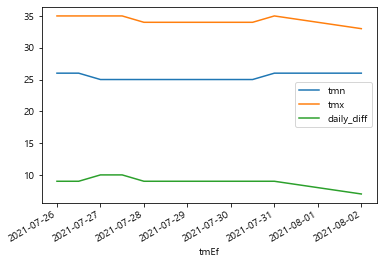

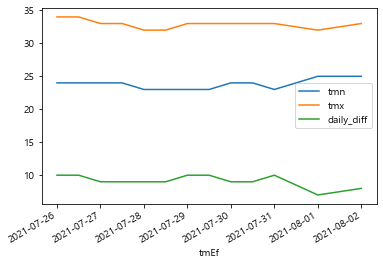

In [75]:
df_time_index[df_time_index['city'] == '서울'].plot()
df_time_index[df_time_index['city'] == '고양'].plot()
plt.show()

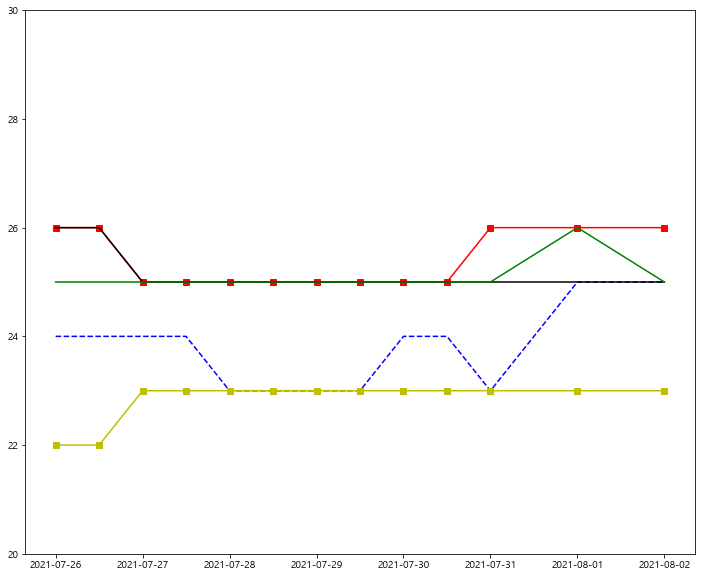

In [72]:
# 5개 지역 최고기온 시계열
plt.figure(figsize = (12, 10))
plt.plot(df_time_index[df_time_index['city'] == '서울']['tmn'], 'rs-')
plt.plot(df_time_index[df_time_index['city'] == '고양']['tmn'], 'b--')
plt.plot(df_time_index[df_time_index['city'] == '인천']['tmn'], 'black')
plt.plot(df_time_index[df_time_index['city'] == '안양']['tmn'], 'green')
plt.plot(df_time_index[df_time_index['city'] == '백령도']['tmn'], 'ys-')
plt.ylim([20, 30])
plt.show()

In [49]:
df_time_index['city'].value_counts()

수원     13
과천     13
양평     13
안양     13
평택     13
군포     13
하남     13
인천     13
오산     13
광명     13
여주     13
구리     13
고양     13
성남     13
부천     13
광주     13
화성     13
연천     13
의정부    13
안산     13
양주     13
서울     13
강화     13
안성     13
이천     13
포천     13
시흥     13
의왕     13
동두천    13
남양주    13
김포     13
백령도    13
파주     13
용인     13
가평     13
Name: city, dtype: int64

In [74]:
# 최고기온 사이드 테이블 
import sidetable 
df.stb.freq(['tmx'])

,tmx,count,percent,cumulative_count,cumulative_percent
0,32,144,31.648352,144,31.648352
1,33,138,30.329670,282,61.978022
2,34,78,17.142857,360,79.120879
3,35,38,8.351648,398,87.472527
4,31,33,7.252747,431,94.725275
5,29,10,2.197802,441,96.923077
6,30,7,1.538462,448,98.461538
7,28,7,1.538462,455,100.000000
